In [65]:
import pandas as pd
from itertools import islice
import numpy as np
import xarray
import json
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import ParameterGrid
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer

import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 
from pycox.models import DeepHitSingle

import torch # For building the networks 
from torch import nn
import torch.nn.functional as F
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import LogisticHazard
from pycox.models import CoxPH
from pycox.models.loss import NLLLogistiHazardLoss, NLLMTLRLoss, BCESurvLoss
from pycox.evaluation import EvalSurv

import seaborn as sn
sn.set_theme(style="white", palette="rocket_r")

np.random.seed(100)
_ = torch.manual_seed(100)

In [66]:
labels = pd.read_csv('preprocessed_labels.csv', index_col='patient')
labels['actualiculos'] = labels['actualiculos']*24
labels.drop(labels.loc[labels['actualiculos']>240].index, inplace=True)

statics = pd.read_csv('preprocessed_flat.csv', index_col='patient')
statics.drop('nullheight', axis=1, inplace=True)

In [67]:
data = statics.merge(labels, left_index=True, right_index=True)

In [69]:
sample_labels = labels.loc[list(set(list(data.index.get_level_values('patient'))))]

df_test = sample_labels.sample(frac=0.2)
df_train = sample_labels.drop(df_test.index)
df_val = sample_labels.sample(frac=0.2)
df_train = sample_labels.drop(df_val.index)

cols_standardize = ['age', 'height', 'weight']
cols_leave = ['gender', 'hour', 'eyes', 'motor', 'verbal',
       'ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_OTHER',
       'ethnicity_UNKNOWN', 'ethnicity_WHITE',
       'ethnicity_WHITE - OTHER EUROPEAN', 'ethnicity_misc',
       'first_careunit_Cardiac Vascular Intensive Care Unit (CVICU)',
       'first_careunit_Coronary Care Unit (CCU)',
       'first_careunit_Medical Intensive Care Unit (MICU)',
       'first_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU)',
       'first_careunit_Neuro Intermediate', 'first_careunit_Neuro Stepdown',
       'first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU)',
       'first_careunit_Surgical Intensive Care Unit (SICU)',
       'first_careunit_Trauma SICU (TSICU)',
       'admission_location_EMERGENCY ROOM',
       'admission_location_PHYSICIAN REFERRAL',
       'admission_location_PROCEDURE SITE',
       'admission_location_TRANSFER FROM HOSPITAL',
       'admission_location_TRANSFER FROM SKILLED NURSING FACILITY',
       'admission_location_WALK-IN/SELF REFERRAL', 'admission_location_misc',
       'insurance_Medicaid', 'insurance_Medicare', 'insurance_Other']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

st = set(list(df_val.index.get_level_values('patient')))
val_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]
st = set(list(df_train.index.get_level_values('patient')))
train_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]
st = set(list(df_test.index.get_level_values('patient')))
test_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]

input_train = data.iloc[list(train_index)]
input_val = data.iloc[val_index]
input_test = data.iloc[test_index]

num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)

get_target = lambda df: (df['actualiculos'].values.astype('float32'), df['actualhospitalmortality'].values.astype('int32'))
y_train = labtrans.fit_transform(*get_target(input_train))
y_val = labtrans.fit_transform(*get_target(input_val))

input_train.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
input_val.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)

x_train = x_mapper.fit_transform(input_train).astype('float32')
x_val = x_mapper.transform(input_val).astype('float32')

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(input_test)

input_test.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)

x_test = x_mapper.transform(input_test).astype('float32')

/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_14687/2710105036.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_train.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_14687/2710105036.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_val.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_14687/2710105036.py:65: SettingWithCopyWarning: 
A value is

# Standard Logistic Hazard

In [76]:
in_features = x_train.shape[1]
num_nodes = [3*in_features, 5*in_features, 3*in_features]
out_features = 10
batch_norm = False
dropout = 0.0
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [77]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

In [78]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [79]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[1s / 1s],		train_loss: 0.3757,	val_loss: 0.3274
1:	[1s / 2s],		train_loss: 0.3281,	val_loss: 0.3202
2:	[1s / 3s],		train_loss: 0.3176,	val_loss: 0.3209
3:	[1s / 4s],		train_loss: 0.3169,	val_loss: 0.3174
4:	[0s / 5s],		train_loss: 0.3140,	val_loss: 0.3130
5:	[0s / 6s],		train_loss: 0.3158,	val_loss: 0.3220
6:	[1s / 7s],		train_loss: 0.3140,	val_loss: 0.3173
7:	[1s / 8s],		train_loss: 0.3114,	val_loss: 0.3140
8:	[1s / 10s],		train_loss: 0.3100,	val_loss: 0.3133
9:	[1s / 11s],		train_loss: 0.3165,	val_loss: 0.3178
10:	[0s / 12s],		train_loss: 0.3111,	val_loss: 0.3144
11:	[0s / 13s],		train_loss: 0.3079,	val_loss: 0.3195
12:	[1s / 14s],		train_loss: 0.3059,	val_loss: 0.3187
13:	[1s / 15s],		train_loss: 0.3055,	val_loss: 0.3173
14:	[2s / 17s],		train_loss: 0.3028,	val_loss: 0.3189


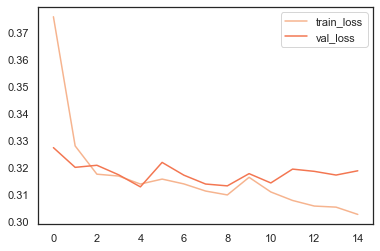

In [80]:
_ = log.plot()

In [81]:
surv = model.predict_surv_df(x_test)

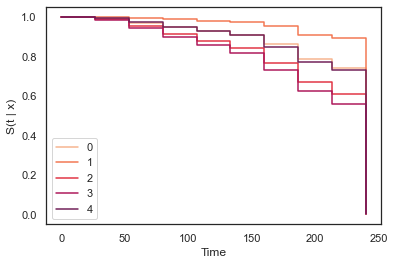

In [82]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [83]:
surv = model.interpolate(10).predict_surv_df(x_test)

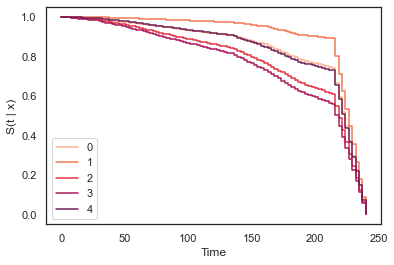

In [84]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [85]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [86]:
ev.concordance_td()

0.8300515475726821

In [87]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.integrated_brier_score(time_grid)

0.12744728364244237

In [88]:
ev.integrated_nbll(time_grid)

0.3990712774212161

# PMF

In [6]:
from pycox.models import PMF

In [7]:

sample_labels = labels.loc[list(set(list(data.index.get_level_values('patient'))))]

df_test = sample_labels.sample(frac=0.2)
df_train = sample_labels.drop(df_test.index)
df_val = sample_labels.sample(frac=0.2)
df_train = sample_labels.drop(df_val.index)

cols_standardize = ['age', 'height', 'weight']
cols_leave = ['gender', 'hour', 'eyes', 'motor', 'verbal',
       'ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_OTHER',
       'ethnicity_UNKNOWN', 'ethnicity_WHITE',
       'ethnicity_WHITE - OTHER EUROPEAN', 'ethnicity_misc',
       'first_careunit_Cardiac Vascular Intensive Care Unit (CVICU)',
       'first_careunit_Coronary Care Unit (CCU)',
       'first_careunit_Medical Intensive Care Unit (MICU)',
       'first_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU)',
       'first_careunit_Neuro Intermediate', 'first_careunit_Neuro Stepdown',
       'first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU)',
       'first_careunit_Surgical Intensive Care Unit (SICU)',
       'first_careunit_Trauma SICU (TSICU)',
       'admission_location_EMERGENCY ROOM',
       'admission_location_PHYSICIAN REFERRAL',
       'admission_location_PROCEDURE SITE',
       'admission_location_TRANSFER FROM HOSPITAL',
       'admission_location_TRANSFER FROM SKILLED NURSING FACILITY',
       'admission_location_WALK-IN/SELF REFERRAL', 'admission_location_misc',
       'insurance_Medicaid', 'insurance_Medicare', 'insurance_Other']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

st = set(list(df_val.index.get_level_values('patient')))
val_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]
st = set(list(df_train.index.get_level_values('patient')))
train_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]
st = set(list(df_test.index.get_level_values('patient')))
test_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]

input_train = data.iloc[list(train_index)]
input_val = data.iloc[val_index]
input_test = data.iloc[test_index]

num_durations = 10
labtrans = PMF.label_transform(num_durations)

get_target = lambda df: (df['actualiculos'].values.astype('float32'), df['actualhospitalmortality'].values.astype('int32'))

y_train = labtrans.fit_transform(*get_target(input_train))
y_val = labtrans.transform(*get_target(input_val))

input_train.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
input_val.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)

x_train = x_mapper.fit_transform(input_train).astype('float32')
x_val = x_mapper.transform(input_val).astype('float32')

val = x_val, y_val

# We don't need to transform the test labels
durations_test, events_test = get_target(input_test)
durations_test = labtrans.transform(*get_target(input_test))[0]

input_test.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)

x_test = x_mapper.transform(input_test).astype('float32')

train = (x_train, y_train)
val = (x_val, y_val)

/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_97758/3067698293.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_train.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_97758/3067698293.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_val.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_97758/3067698293.py:65: SettingWithCopyWarning: 
A value is

In [8]:
in_features = x_train.shape[1]
num_nodes = [3*in_features, 5*in_features, 3*in_features]
out_features = labtrans.out_features
batch_norm = False
dropout = 0.0
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [9]:
model = PMF(net, tt.optim.Adam, duration_index=labtrans.cuts)

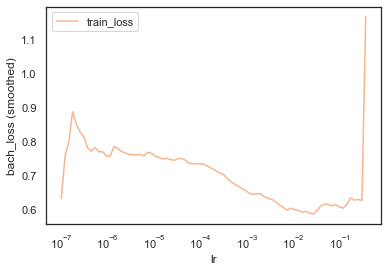

In [10]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=4)
_ = lr_finder.plot()

In [11]:
lr_finder.get_best_lr()

0.002595024211399749

In [12]:
model.optimizer.set_lr(lr_finder.get_best_lr())

In [13]:
callbacks = [tt.cb.EarlyStopping(patience=10)]
epochs = 100
verbose = True

In [14]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[1s / 1s],		train_loss: 0.3539,	val_loss: 0.3292
1:	[1s / 2s],		train_loss: 0.3224,	val_loss: 0.3194
2:	[1s / 3s],		train_loss: 0.3204,	val_loss: 0.3174
3:	[1s / 4s],		train_loss: 0.3155,	val_loss: 0.3177
4:	[1s / 5s],		train_loss: 0.3129,	val_loss: 0.3167
5:	[0s / 6s],		train_loss: 0.3117,	val_loss: 0.3144
6:	[0s / 7s],		train_loss: 0.3097,	val_loss: 0.3150
7:	[1s / 8s],		train_loss: 0.3080,	val_loss: 0.3155
8:	[1s / 10s],		train_loss: 0.3060,	val_loss: 0.3224
9:	[1s / 12s],		train_loss: 0.3040,	val_loss: 0.3172
10:	[0s / 13s],		train_loss: 0.3026,	val_loss: 0.3168
11:	[1s / 14s],		train_loss: 0.3001,	val_loss: 0.3187
12:	[0s / 15s],		train_loss: 0.2972,	val_loss: 0.3180
13:	[0s / 16s],		train_loss: 0.2955,	val_loss: 0.3214
14:	[0s / 17s],		train_loss: 0.2948,	val_loss: 0.3207
15:	[2s / 19s],		train_loss: 0.2902,	val_loss: 0.3288


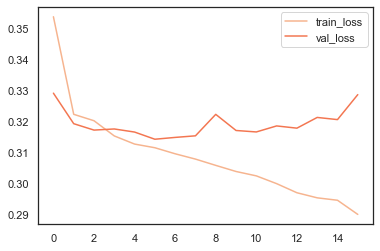

In [15]:
_ = log.plot()

In [16]:
surv = model.predict_surv_df(x_test)

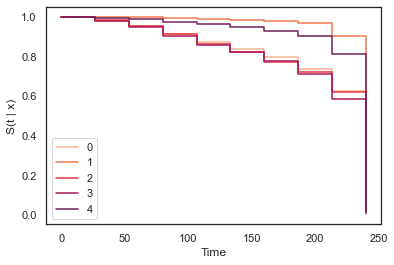

In [17]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [18]:
surv = model.interpolate(10).predict_surv_df(x_test)

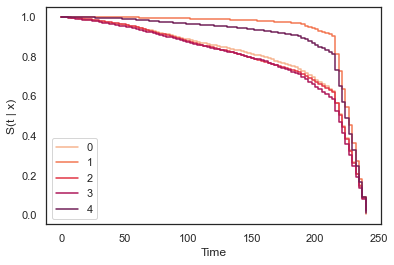

In [19]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [20]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [21]:
ev.concordance_td('antolini')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


0.58968576711763

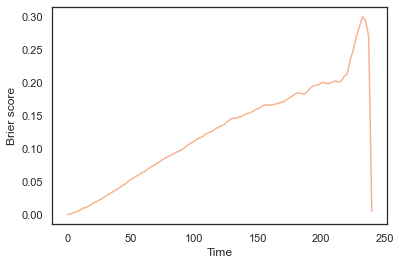

In [22]:
input_test = data.iloc[test_index]
durations_test, events_test = get_target(input_test)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

In [23]:
ev.integrated_brier_score(time_grid) 

0.12570636640637584

In [24]:
ev.integrated_nbll(time_grid) 

0.38870134731611805

# DeepHit

In [239]:
from pycox.models import DeepHitSingle

In [25]:

sample_labels = labels.loc[list(set(list(data.index.get_level_values('patient'))))]

df_test = sample_labels.sample(frac=0.2)
df_train = sample_labels.drop(df_test.index)
df_val = sample_labels.sample(frac=0.2)
df_train = sample_labels.drop(df_val.index)

cols_standardize = ['age', 'height', 'weight']
cols_leave = ['gender', 'hour', 'eyes', 'motor', 'verbal',
       'ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_OTHER',
       'ethnicity_UNKNOWN', 'ethnicity_WHITE',
       'ethnicity_WHITE - OTHER EUROPEAN', 'ethnicity_misc',
       'first_careunit_Cardiac Vascular Intensive Care Unit (CVICU)',
       'first_careunit_Coronary Care Unit (CCU)',
       'first_careunit_Medical Intensive Care Unit (MICU)',
       'first_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU)',
       'first_careunit_Neuro Intermediate', 'first_careunit_Neuro Stepdown',
       'first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU)',
       'first_careunit_Surgical Intensive Care Unit (SICU)',
       'first_careunit_Trauma SICU (TSICU)',
       'admission_location_EMERGENCY ROOM',
       'admission_location_PHYSICIAN REFERRAL',
       'admission_location_PROCEDURE SITE',
       'admission_location_TRANSFER FROM HOSPITAL',
       'admission_location_TRANSFER FROM SKILLED NURSING FACILITY',
       'admission_location_WALK-IN/SELF REFERRAL', 'admission_location_misc',
       'insurance_Medicaid', 'insurance_Medicare', 'insurance_Other']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

st = set(list(df_val.index.get_level_values('patient')))
val_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]
st = set(list(df_train.index.get_level_values('patient')))
train_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]
st = set(list(df_test.index.get_level_values('patient')))
test_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]

input_train = data.iloc[list(train_index)]
input_val = data.iloc[val_index]
input_test = data.iloc[test_index]

num_durations = 10
labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['actualiculos'].values.astype('float32'), df['actualhospitalmortality'].values.astype('int32'))

y_train = labtrans.fit_transform(*get_target(input_train))
y_val = labtrans.transform(*get_target(input_val))

input_train.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
input_val.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)

x_train = x_mapper.fit_transform(input_train).astype('float32')
x_val = x_mapper.transform(input_val).astype('float32')

val = x_val, y_val

# We don't need to transform the test labels
durations_test, events_test = get_target(input_test)
durations_test = labtrans.transform(*get_target(input_test))[0]

input_test.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)

x_test = x_mapper.transform(input_test).astype('float32')

train = (x_train, y_train)
val = (x_val, y_val)

/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_97758/2958440053.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_train.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_97758/2958440053.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_val.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_97758/2958440053.py:65: SettingWithCopyWarning: 
A value is

In [26]:
in_features = x_train.shape[1]
num_nodes = [3*in_features, 5*in_features, 3*in_features]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.6
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [27]:
model = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

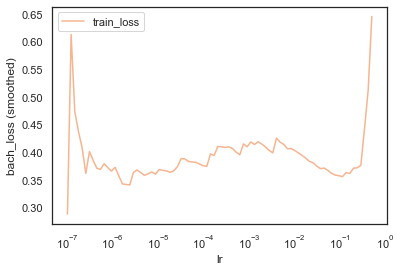

In [28]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=4)
_ = lr_finder.plot()

In [29]:
lr_finder.get_best_lr()

0.0001

In [30]:
model.optimizer.set_lr(lr_finder.get_best_lr())

In [31]:
callbacks = [tt.cb.EarlyStopping()]
epochs = 100
verbose = True

In [32]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[3s / 3s],		train_loss: 0.3319,	val_loss: 2.0579
1:	[4s / 7s],		train_loss: 0.2759,	val_loss: 0.9621
2:	[3s / 11s],		train_loss: 0.2426,	val_loss: 1.8995
3:	[4s / 15s],		train_loss: 0.2332,	val_loss: 0.7422
4:	[4s / 20s],		train_loss: 0.2059,	val_loss: 2.7767
5:	[3s / 23s],		train_loss: 0.1988,	val_loss: 0.9688
6:	[3s / 26s],		train_loss: 0.1854,	val_loss: 1.5060
7:	[3s / 30s],		train_loss: 0.1811,	val_loss: 1.1892
8:	[3s / 34s],		train_loss: 0.1806,	val_loss: 1.5006
9:	[3s / 37s],		train_loss: 0.1778,	val_loss: 0.8500
10:	[3s / 41s],		train_loss: 0.1728,	val_loss: 0.7089
11:	[3s / 44s],		train_loss: 0.1686,	val_loss: 1.6562
12:	[3s / 47s],		train_loss: 0.1627,	val_loss: 0.8916
13:	[4s / 52s],		train_loss: 0.1638,	val_loss: 1.2277
14:	[3s / 55s],		train_loss: 0.1607,	val_loss: 0.6524
15:	[4s / 59s],		train_loss: 0.1580,	val_loss: 0.9247
16:	[3s / 1m:3s],		train_loss: 0.1551,	val_loss: 0.4404
17:	[3s / 1m:7s],		train_loss: 0.1521,	val_loss: 0.6681
18:	[3s / 1m:10s],		train_loss: 0.14

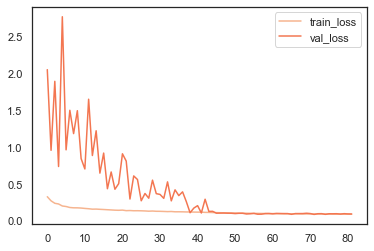

In [33]:
_ = log.plot()

In [34]:
surv = model.predict_surv_df(x_test)

In [35]:
surv = model.interpolate(10).predict_surv_df(x_test)

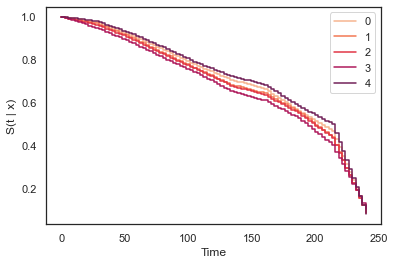

In [36]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [37]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [38]:
ev.concordance_td('antolini')

0.7920739137918112

In [39]:
input_test = data.iloc[test_index]
durations_test, events_test = get_target(input_test)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)

In [40]:
ev.integrated_brier_score(time_grid) 

0.13658913729529615

In [41]:
ev.integrated_nbll(time_grid) 

0.42147811506727056

In [ ]:
dropout = [0.0, 0.1, 0.3, 0.5]
batch_size = [32, 64, 128, 256, 512]
nodes = [16, 32, 64]
c = []
for d in dropout:
    for b in batch_size:
        for n in nodes:
            in_features = x_train.shape[1]
            num_nodes = [n]*2
            out_features = labtrans.out_features
            batch_norm = True
            dropout = d

            net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
            model = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)
            lr_finder = model.lr_finder(x_train, y_train, b, tolerance=3)
            model.optimizer.set_lr(lr_finder.get_best_lr())
            epochs = 100
            callbacks = [tt.callbacks.EarlyStopping()]
            log = model.fit(x_train, y_train, b, epochs, callbacks, False, val_data=val)
            surv = model.predict_surv_df(x_test)
            ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
            c.append(ev.concordance_td('antolini'))

# MTLR

In [291]:
from pycox.models import MTLR

In [328]:

sample_labels = labels.loc[list(set(list(data.index.get_level_values('patient'))))]

df_test = sample_labels.sample(frac=0.2)
df_train = sample_labels.drop(df_test.index)
df_val = sample_labels.sample(frac=0.2)
df_train = sample_labels.drop(df_val.index)

cols_standardize = ['age', 'height', 'weight']
cols_leave = ['gender', 'hour', 'eyes', 'motor', 'verbal',
       'ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_OTHER',
       'ethnicity_UNKNOWN', 'ethnicity_WHITE',
       'ethnicity_WHITE - OTHER EUROPEAN', 'ethnicity_misc',
       'first_careunit_Cardiac Vascular Intensive Care Unit (CVICU)',
       'first_careunit_Coronary Care Unit (CCU)',
       'first_careunit_Medical Intensive Care Unit (MICU)',
       'first_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU)',
       'first_careunit_Neuro Intermediate', 'first_careunit_Neuro Stepdown',
       'first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU)',
       'first_careunit_Surgical Intensive Care Unit (SICU)',
       'first_careunit_Trauma SICU (TSICU)',
       'admission_location_EMERGENCY ROOM',
       'admission_location_PHYSICIAN REFERRAL',
       'admission_location_PROCEDURE SITE',
       'admission_location_TRANSFER FROM HOSPITAL',
       'admission_location_TRANSFER FROM SKILLED NURSING FACILITY',
       'admission_location_WALK-IN/SELF REFERRAL', 'admission_location_misc',
       'insurance_Medicaid', 'insurance_Medicare', 'insurance_Other']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

st = set(list(df_val.index.get_level_values('patient')))
val_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]
st = set(list(df_train.index.get_level_values('patient')))
train_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]
st = set(list(df_test.index.get_level_values('patient')))
test_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]

input_train = data.iloc[list(train_index)]
input_val = data.iloc[val_index]
input_test = data.iloc[test_index]

num_durations = 10
labtrans = MTLR.label_transform(num_durations)

get_target = lambda df: (df['actualiculos'].values.astype('float32'), df['actualhospitalmortality'].values.astype('int32'))

y_train = labtrans.fit_transform(*get_target(input_train))
y_val = labtrans.transform(*get_target(input_val))

input_train.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
input_val.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)

x_train = x_mapper.fit_transform(input_train).astype('float32')
x_val = x_mapper.transform(input_val).astype('float32')

val = x_val, y_val

# We don't need to transform the test labels
durations_test, events_test = get_target(input_test)
durations_test = labtrans.transform(*get_target(input_test))[0]

input_test.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)

x_test = x_mapper.transform(input_test).astype('float32')

train = (x_train, y_train)
val = (x_val, y_val)

/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_93342/1073199952.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_train.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_93342/1073199952.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_val.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_93342/1073199952.py:65: SettingWithCopyWarning: 
A value is

In [332]:
in_features = x_train.shape[1]
num_nodes = [3*in_features, 5*in_features, 3*in_features]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.5
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [333]:
model = MTLR(net, tt.optim.Adam, duration_index=labtrans.cuts)

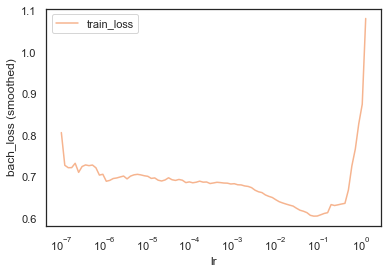

In [334]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=6)
_ = lr_finder.plot()

In [335]:
lr_finder.get_best_lr()

0.007924828983539215

In [336]:
model.optimizer.set_lr(lr_finder.get_best_lr())

In [337]:
callbacks = [tt.cb.EarlyStopping()]
epochs = 100
verbose = True

In [338]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[1s / 1s],		train_loss: 0.4059,	val_loss: 0.3297
1:	[1s / 3s],		train_loss: 0.3513,	val_loss: 0.3177
2:	[2s / 5s],		train_loss: 0.3369,	val_loss: 0.3134
3:	[2s / 8s],		train_loss: 0.3310,	val_loss: 0.3150
4:	[1s / 9s],		train_loss: 0.3283,	val_loss: 0.3153
5:	[1s / 11s],		train_loss: 0.3273,	val_loss: 0.3154
6:	[1s / 13s],		train_loss: 0.3249,	val_loss: 0.3115
7:	[1s / 15s],		train_loss: 0.3234,	val_loss: 0.3237
8:	[1s / 17s],		train_loss: 0.3239,	val_loss: 0.3149
9:	[1s / 19s],		train_loss: 0.3242,	val_loss: 0.3174
10:	[1s / 20s],		train_loss: 0.3237,	val_loss: 0.3090
11:	[1s / 22s],		train_loss: 0.3228,	val_loss: 0.3193
12:	[2s / 25s],		train_loss: 0.3230,	val_loss: 0.3164
13:	[1s / 26s],		train_loss: 0.3226,	val_loss: 0.3235
14:	[1s / 28s],		train_loss: 0.3217,	val_loss: 0.3183
15:	[1s / 30s],		train_loss: 0.3213,	val_loss: 0.3126
16:	[1s / 32s],		train_loss: 0.3226,	val_loss: 0.3153
17:	[2s / 34s],		train_loss: 0.3203,	val_loss: 0.3049
18:	[1s / 36s],		train_loss: 0.3217,	val_lo

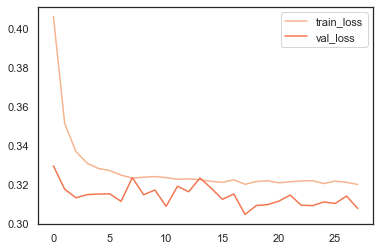

In [339]:
_ = log.plot()

In [340]:
surv = model.predict_surv_df(x_test)

In [341]:
surv = model.interpolate(10).predict_surv_df(x_test)

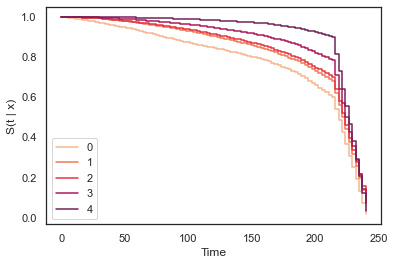

In [342]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [353]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [344]:
ev.concordance_td('antolini')

0.7644468445547236

In [354]:
input_test = data.iloc[test_index]
durations_test, events_test = get_target(input_test)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)

In [355]:
ev.integrated_brier_score(time_grid) 

0.12621520876989653

In [356]:
ev.integrated_nbll(time_grid) 

0.3896653623175626

# BCESurv

In [42]:
from pycox.models import BCESurv

In [51]:
sample_labels = labels.loc[list(set(list(data.index.get_level_values('patient'))))]

df_test = sample_labels.sample(frac=0.2)
df_train = sample_labels.drop(df_test.index)
df_val = sample_labels.sample(frac=0.2)
df_train = sample_labels.drop(df_val.index)

cols_standardize = ['age', 'height', 'weight']
cols_leave = ['gender', 'hour', 'eyes', 'motor', 'verbal',
       'ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_OTHER',
       'ethnicity_UNKNOWN', 'ethnicity_WHITE',
       'ethnicity_WHITE - OTHER EUROPEAN', 'ethnicity_misc',
       'first_careunit_Cardiac Vascular Intensive Care Unit (CVICU)',
       'first_careunit_Coronary Care Unit (CCU)',
       'first_careunit_Medical Intensive Care Unit (MICU)',
       'first_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU)',
       'first_careunit_Neuro Intermediate', 'first_careunit_Neuro Stepdown',
       'first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU)',
       'first_careunit_Surgical Intensive Care Unit (SICU)',
       'first_careunit_Trauma SICU (TSICU)',
       'admission_location_EMERGENCY ROOM',
       'admission_location_PHYSICIAN REFERRAL',
       'admission_location_PROCEDURE SITE',
       'admission_location_TRANSFER FROM HOSPITAL',
       'admission_location_TRANSFER FROM SKILLED NURSING FACILITY',
       'admission_location_WALK-IN/SELF REFERRAL', 'admission_location_misc',
       'insurance_Medicaid', 'insurance_Medicare', 'insurance_Other']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

st = set(list(df_val.index.get_level_values('patient')))
val_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]
st = set(list(df_train.index.get_level_values('patient')))
train_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]
st = set(list(df_test.index.get_level_values('patient')))
test_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]

input_train = data.iloc[list(train_index)]
input_val = data.iloc[val_index]
input_test = data.iloc[test_index]

n_durations = 10
labtrans = LogisticHazard.label_transform(n_durations)

get_target = lambda df: (df['actualiculos'].values.astype('float32'), df['actualhospitalmortality'].values.astype('int32'))
y_train = labtrans.fit_transform(*get_target(input_train))
y_val = labtrans.fit_transform(*get_target(input_val))
y_test = labtrans.transform(*get_target(input_test))

input_train.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
input_val.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)

x_train = x_mapper.fit_transform(input_train).astype('float32')
x_val = x_mapper.transform(input_val).astype('float32')

train = tt.tuplefy(x_train, y_train)
val = tt.tuplefy(x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(input_test)
durations_test = labtrans.transform(*get_target(input_test))[0]

input_test.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)

x_test = x_mapper.transform(input_test).astype('float32')
test = tt.tuplefy(x_test, y_test)

/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_97758/2243940398.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_train.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_97758/2243940398.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_val.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_97758/2243940398.py:65: SettingWithCopyWarning: 
A value is

In [53]:
def make_net(train, labtrans, dropout=0.0):
    in_features = train[0].shape[1]
    out_features = labtrans.out_features
    num_nodes = [3*in_features, 5*in_features, 3*in_features]
    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features,
                                  dropout=dropout)
    return net

In [54]:
def fit_and_predict(model_class, train, val, test, labtrans, lr=0.01, n_itp=20):
    net = make_net(train, labtrans)
    model = model_class(net, tt.optim.AdamWR(lr, cycle_eta_multiplier=0.8), duration_index=labtrans.cuts)
    log = model.fit(*train, 256, 256, verbose=False, val_data=val,
                    callbacks=[tt.cb.EarlyStoppingCycle()])
    surv = model.interpolate(n_itp).predict_surv_df(test[0])
    return surv, model

In [57]:
surv_bce, model_bce = fit_and_predict(BCESurv, train, val, test, labtrans, lr=0.0001)

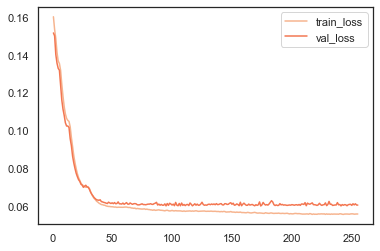

In [58]:
_ = model_bce.log.to_pandas().iloc[1:].plot()

In [59]:
ev_bce_true = EvalSurv(surv_bce, durations_test, events_test, 'km')

In [60]:
ev.concordance_td('antolini')

0.8223355085868335

In [61]:
time_grid = np.linspace(0, 100, 100)

In [62]:
input_test = data.iloc[test_index]
durations_test, events_test = get_target(input_test)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)

In [63]:
ev.integrated_brier_score(time_grid) 

0.15660519011775104

In [64]:
ev.integrated_nbll(time_grid) 

0.47327549550138154

# CoxTime

In [4]:
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime

In [16]:

sample_labels = labels.loc[list(set(list(data.index.get_level_values('patient'))))]

df_test = sample_labels.sample(frac=0.2)
df_train = sample_labels.drop(df_test.index)
df_val = sample_labels.sample(frac=0.2)
df_train = sample_labels.drop(df_val.index)

cols_standardize = ['age', 'height', 'weight']
cols_leave = ['gender', 'hour', 'eyes', 'motor', 'verbal',
       'ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_OTHER',
       'ethnicity_UNKNOWN', 'ethnicity_WHITE',
       'ethnicity_WHITE - OTHER EUROPEAN', 'ethnicity_misc',
       'first_careunit_Cardiac Vascular Intensive Care Unit (CVICU)',
       'first_careunit_Coronary Care Unit (CCU)',
       'first_careunit_Medical Intensive Care Unit (MICU)',
       'first_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU)',
       'first_careunit_Neuro Intermediate', 'first_careunit_Neuro Stepdown',
       'first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU)',
       'first_careunit_Surgical Intensive Care Unit (SICU)',
       'first_careunit_Trauma SICU (TSICU)',
       'admission_location_EMERGENCY ROOM',
       'admission_location_PHYSICIAN REFERRAL',
       'admission_location_PROCEDURE SITE',
       'admission_location_TRANSFER FROM HOSPITAL',
       'admission_location_TRANSFER FROM SKILLED NURSING FACILITY',
       'admission_location_WALK-IN/SELF REFERRAL', 'admission_location_misc',
       'insurance_Medicaid', 'insurance_Medicare', 'insurance_Other']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

st = set(list(df_val.index.get_level_values('patient')))
val_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]
st = set(list(df_train.index.get_level_values('patient')))
train_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]
st = set(list(df_test.index.get_level_values('patient')))
test_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]

input_train = data.iloc[list(train_index)]
input_val = data.iloc[val_index]
input_test = data.iloc[test_index]

num_durations = 10
labtrans = CoxTime.label_transform()

get_target = lambda df: (df['actualiculos'].values.astype('float32'), df['actualhospitalmortality'].values.astype('int32'))

y_train = labtrans.fit_transform(*get_target(input_train))
y_val = labtrans.transform(*get_target(input_val))

input_train.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
input_val.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)

x_train = x_mapper.fit_transform(input_train).astype('float32')
x_val = x_mapper.transform(input_val).astype('float32')

val = tt.tuplefy(x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(input_test)
durations_test = labtrans.transform(*get_target(input_test))[0]

input_test.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)

x_test = x_mapper.transform(input_test).astype('float32')

/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_12715/2116763194.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_train.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_12715/2116763194.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_val.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_12715/2116763194.py:65: SettingWithCopyWarning: 
A value is

In [17]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.5
output_bias = False
net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

In [18]:
model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)

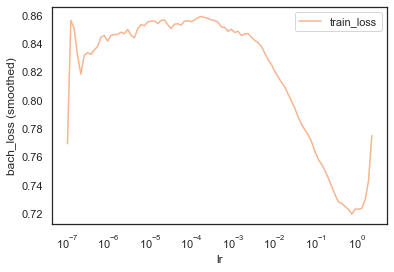

In [19]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

In [20]:
lrfinder.get_best_lr()

0.07390722033525823

In [21]:
model.optimizer.set_lr(lrfinder.get_best_lr())

In [22]:
callbacks = [tt.cb.EarlyStopping(patience=10)]
epochs = 100
verbose = True

In [23]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())

0:	[0s / 0s],		train_loss: 0.6012,	val_loss: 0.4893
1:	[0s / 0s],		train_loss: 0.5250,	val_loss: 0.4634
2:	[0s / 0s],		train_loss: 0.4937,	val_loss: 0.4608
3:	[0s / 0s],		train_loss: 0.4902,	val_loss: 0.4444
4:	[0s / 0s],		train_loss: 0.5019,	val_loss: 0.4833
5:	[0s / 1s],		train_loss: 0.4950,	val_loss: 0.4510
6:	[0s / 1s],		train_loss: 0.4960,	val_loss: 0.4402
7:	[0s / 1s],		train_loss: 0.4787,	val_loss: 0.4455
8:	[0s / 1s],		train_loss: 0.4760,	val_loss: 0.4483
9:	[0s / 1s],		train_loss: 0.4779,	val_loss: 0.4531
10:	[0s / 1s],		train_loss: 0.4880,	val_loss: 0.4462
11:	[0s / 2s],		train_loss: 0.4808,	val_loss: 0.4425
12:	[0s / 2s],		train_loss: 0.4851,	val_loss: 0.4361
13:	[0s / 2s],		train_loss: 0.4718,	val_loss: 0.4384
14:	[0s / 2s],		train_loss: 0.4846,	val_loss: 0.4469
15:	[0s / 2s],		train_loss: 0.4802,	val_loss: 0.4416
16:	[0s / 3s],		train_loss: 0.4684,	val_loss: 0.4494
17:	[0s / 3s],		train_loss: 0.4846,	val_loss: 0.4846
18:	[0s / 3s],		train_loss: 0.4866,	val_loss: 0.4498
19:

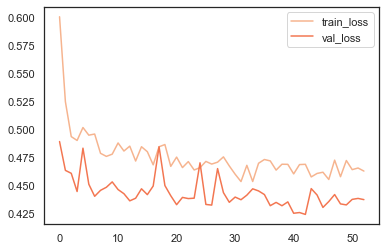

In [24]:
_ = log.plot()

In [25]:
_ = model.compute_baseline_hazards()

In [ ]:
surv = model.predict_surv_df(x_test)

In [ ]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [ ]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev.concordance_td('antolini')

In [ ]:
input_test = data.iloc[test_index]
durations_test, events_test = get_target(input_test)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)

In [ ]:
ev.integrated_brier_score(time_grid) 

In [ ]:
ev.integrated_nbll(time_grid) 

# CoxCC

In [4]:
from pycox.models import CoxCC

In [7]:

sample_labels = labels.loc[list(set(list(data.index.get_level_values('patient'))))]

df_test = sample_labels.sample(frac=0.2)
df_train = sample_labels.drop(df_test.index)
df_val = sample_labels.sample(frac=0.2)
df_train = sample_labels.drop(df_val.index)

cols_standardize = ['age', 'height', 'weight']
cols_leave = ['gender', 'hour', 'eyes', 'motor', 'verbal',
       'ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_OTHER',
       'ethnicity_UNKNOWN', 'ethnicity_WHITE',
       'ethnicity_WHITE - OTHER EUROPEAN', 'ethnicity_misc',
       'first_careunit_Cardiac Vascular Intensive Care Unit (CVICU)',
       'first_careunit_Coronary Care Unit (CCU)',
       'first_careunit_Medical Intensive Care Unit (MICU)',
       'first_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU)',
       'first_careunit_Neuro Intermediate', 'first_careunit_Neuro Stepdown',
       'first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU)',
       'first_careunit_Surgical Intensive Care Unit (SICU)',
       'first_careunit_Trauma SICU (TSICU)',
       'admission_location_EMERGENCY ROOM',
       'admission_location_PHYSICIAN REFERRAL',
       'admission_location_PROCEDURE SITE',
       'admission_location_TRANSFER FROM HOSPITAL',
       'admission_location_TRANSFER FROM SKILLED NURSING FACILITY',
       'admission_location_WALK-IN/SELF REFERRAL', 'admission_location_misc',
       'insurance_Medicaid', 'insurance_Medicare', 'insurance_Other']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

st = set(list(df_val.index.get_level_values('patient')))
val_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]
st = set(list(df_train.index.get_level_values('patient')))
train_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]
st = set(list(df_test.index.get_level_values('patient')))
test_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]

input_train = data.iloc[list(train_index)]
input_val = data.iloc[val_index]
input_test = data.iloc[test_index]

get_target = lambda df: (df['actualiculos'].values.astype('float32'), df['actualhospitalmortality'].values.astype('int32'))

y_train = get_target(input_train)
y_val = get_target(input_val)

input_train.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
input_val.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)

x_train = x_mapper.fit_transform(input_train).astype('float32')
x_val = x_mapper.transform(input_val).astype('float32')

val = tt.tuplefy(x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(input_test)

input_test.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)

x_test = x_mapper.transform(input_test).astype('float32')

/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_7996/3432915554.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_train.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_7996/3432915554.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_val.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_7996/3432915554.py:61: SettingWithCopyWarning: 
A value is tr

In [49]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.5
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [50]:
model = CoxCC(net, tt.optim.Adam)

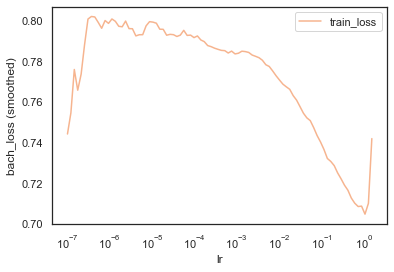

In [51]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

In [52]:
lrfinder.get_best_lr()

0.10722672220103299

In [53]:
model.optimizer.set_lr(lrfinder.get_best_lr())

In [54]:
callbacks = [tt.cb.EarlyStopping(patience=10)]
epochs = 100
verbose = True

In [55]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())

0:	[0s / 0s],		train_loss: 0.6434,	val_loss: 0.4924
1:	[0s / 0s],		train_loss: 0.5464,	val_loss: 0.4946
2:	[0s / 0s],		train_loss: 0.5203,	val_loss: 0.4669
3:	[0s / 0s],		train_loss: 0.4944,	val_loss: 0.4592
4:	[0s / 0s],		train_loss: 0.5056,	val_loss: 0.4520
5:	[0s / 1s],		train_loss: 0.4980,	val_loss: 0.4619
6:	[0s / 1s],		train_loss: 0.4913,	val_loss: 0.4467
7:	[0s / 1s],		train_loss: 0.4921,	val_loss: 0.4459
8:	[0s / 1s],		train_loss: 0.4920,	val_loss: 0.4458
9:	[0s / 2s],		train_loss: 0.4943,	val_loss: 0.4466
10:	[0s / 2s],		train_loss: 0.4842,	val_loss: 0.4410
11:	[0s / 2s],		train_loss: 0.4972,	val_loss: 0.4713
12:	[0s / 2s],		train_loss: 0.4828,	val_loss: 0.4421
13:	[0s / 2s],		train_loss: 0.4788,	val_loss: 0.4587
14:	[0s / 2s],		train_loss: 0.4826,	val_loss: 0.4436
15:	[0s / 2s],		train_loss: 0.4819,	val_loss: 0.4523
16:	[0s / 2s],		train_loss: 0.4939,	val_loss: 0.4644
17:	[0s / 3s],		train_loss: 0.4828,	val_loss: 0.4597
18:	[0s / 3s],		train_loss: 0.4807,	val_loss: 0.4520
19:

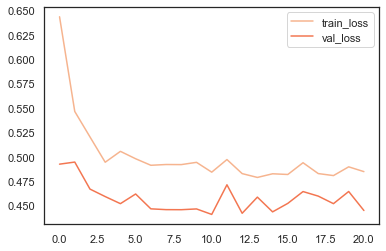

In [56]:
_ = log.plot()

In [57]:
_ = model.compute_baseline_hazards()

In [58]:
surv = model.predict_surv_df(x_test)

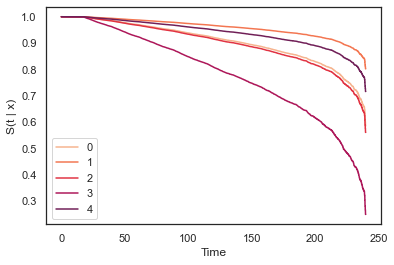

In [59]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [60]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev.concordance_td('antolini')

0.8290564662934654

In [61]:
input_test = data.iloc[test_index]
durations_test, events_test = get_target(input_test)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)

In [62]:
ev.integrated_brier_score(time_grid) 

0.12303476458321726

In [63]:
ev.integrated_nbll(time_grid) 

0.39320240057237693

# DeepSurv

In [4]:
from pycox.models import CoxPH

In [5]:

sample_labels = labels.loc[list(set(list(data.index.get_level_values('patient'))))]

df_test = sample_labels.sample(frac=0.2)
df_train = sample_labels.drop(df_test.index)
df_val = sample_labels.sample(frac=0.2)
df_train = sample_labels.drop(df_val.index)

cols_standardize = ['age', 'height', 'weight']
cols_leave = ['gender', 'hour', 'eyes', 'motor', 'verbal',
       'ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_OTHER',
       'ethnicity_UNKNOWN', 'ethnicity_WHITE',
       'ethnicity_WHITE - OTHER EUROPEAN', 'ethnicity_misc',
       'first_careunit_Cardiac Vascular Intensive Care Unit (CVICU)',
       'first_careunit_Coronary Care Unit (CCU)',
       'first_careunit_Medical Intensive Care Unit (MICU)',
       'first_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU)',
       'first_careunit_Neuro Intermediate', 'first_careunit_Neuro Stepdown',
       'first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU)',
       'first_careunit_Surgical Intensive Care Unit (SICU)',
       'first_careunit_Trauma SICU (TSICU)',
       'admission_location_EMERGENCY ROOM',
       'admission_location_PHYSICIAN REFERRAL',
       'admission_location_PROCEDURE SITE',
       'admission_location_TRANSFER FROM HOSPITAL',
       'admission_location_TRANSFER FROM SKILLED NURSING FACILITY',
       'admission_location_WALK-IN/SELF REFERRAL', 'admission_location_misc',
       'insurance_Medicaid', 'insurance_Medicare', 'insurance_Other']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

st = set(list(df_val.index.get_level_values('patient')))
val_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]
st = set(list(df_train.index.get_level_values('patient')))
train_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]
st = set(list(df_test.index.get_level_values('patient')))
test_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]

input_train = data.iloc[list(train_index)]
input_val = data.iloc[val_index]
input_test = data.iloc[test_index]

get_target = lambda df: (df['actualiculos'].values.astype('float32'), df['actualhospitalmortality'].values.astype('int32'))

y_train = get_target(input_train)
y_val = get_target(input_val)

input_train.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
input_val.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)

x_train = x_mapper.fit_transform(input_train).astype('float32')
x_val = x_mapper.transform(input_val).astype('float32')

val = x_val, y_val

# We don't need to transform the test labels
durations_test, events_test = get_target(input_test)

input_test.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)

x_test = x_mapper.transform(input_test).astype('float32')

/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_14687/2858813610.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_train.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_14687/2858813610.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_val.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_14687/2858813610.py:61: SettingWithCopyWarning: 
A value is

In [22]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.5
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [23]:
model = CoxPH(net, tt.optim.Adam)

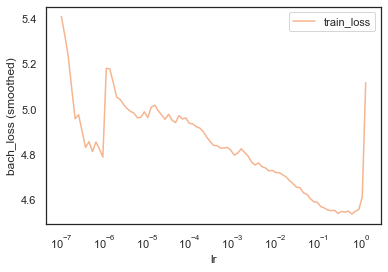

In [24]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [25]:
lrfinder.get_best_lr()

0.0613590727341321

In [26]:
model.optimizer.set_lr(lrfinder.get_best_lr())

In [27]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [28]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[1s / 1s],		train_loss: 3.9951,	val_loss: 3.8065
1:	[0s / 1s],		train_loss: 3.8655,	val_loss: 3.8290
2:	[0s / 2s],		train_loss: 3.8493,	val_loss: 3.7258
3:	[0s / 2s],		train_loss: 3.8666,	val_loss: 3.7253
4:	[0s / 3s],		train_loss: 3.8217,	val_loss: 3.6179
5:	[0s / 4s],		train_loss: 3.8153,	val_loss: 3.6662
6:	[0s / 5s],		train_loss: 3.8171,	val_loss: 3.5990
7:	[0s / 5s],		train_loss: 3.8229,	val_loss: 3.6269
8:	[0s / 6s],		train_loss: 3.8007,	val_loss: 3.5983
9:	[0s / 7s],		train_loss: 3.8282,	val_loss: 3.6857
10:	[0s / 7s],		train_loss: 3.7874,	val_loss: 3.8448
11:	[0s / 8s],		train_loss: 3.7675,	val_loss: 3.6212
12:	[0s / 8s],		train_loss: 3.8027,	val_loss: 3.6585
13:	[1s / 10s],		train_loss: 3.8017,	val_loss: 3.5951
14:	[0s / 10s],		train_loss: 3.7631,	val_loss: 4.9815
15:	[0s / 11s],		train_loss: 3.8018,	val_loss: 3.6791
16:	[0s / 11s],		train_loss: 3.7986,	val_loss: 3.6987
17:	[0s / 12s],		train_loss: 3.7847,	val_loss: 3.6883
18:	[0s / 13s],		train_loss: 3.7807,	val_loss: 3.63

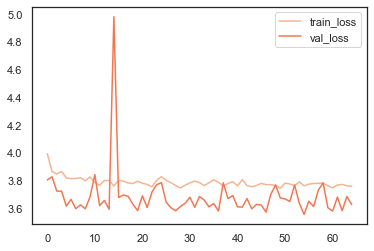

In [29]:
_ = log.plot()

In [30]:
_ = model.compute_baseline_hazards()

In [31]:
surv = model.predict_surv_df(x_test)

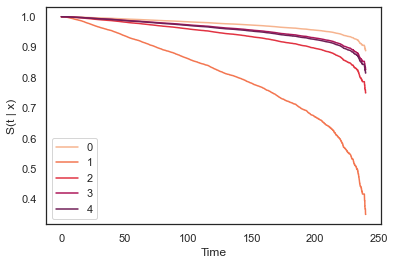

In [32]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [33]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [34]:
ev.concordance_td()

0.8215312458356125

In [35]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)

In [36]:
ev.integrated_brier_score(time_grid)

0.12832167569327627

In [37]:
ev.integrated_nbll(time_grid)

0.4034810681423046

# PCHazard

In [38]:
from pycox.models import PCHazard

In [40]:

sample_labels = labels.loc[list(set(list(data.index.get_level_values('patient'))))]

df_test = sample_labels.sample(frac=0.2)
df_train = sample_labels.drop(df_test.index)
df_val = sample_labels.sample(frac=0.2)
df_train = sample_labels.drop(df_val.index)

cols_standardize = ['age', 'height', 'weight']
cols_leave = ['gender', 'hour', 'eyes', 'motor', 'verbal',
       'ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_OTHER',
       'ethnicity_UNKNOWN', 'ethnicity_WHITE',
       'ethnicity_WHITE - OTHER EUROPEAN', 'ethnicity_misc',
       'first_careunit_Cardiac Vascular Intensive Care Unit (CVICU)',
       'first_careunit_Coronary Care Unit (CCU)',
       'first_careunit_Medical Intensive Care Unit (MICU)',
       'first_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU)',
       'first_careunit_Neuro Intermediate', 'first_careunit_Neuro Stepdown',
       'first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU)',
       'first_careunit_Surgical Intensive Care Unit (SICU)',
       'first_careunit_Trauma SICU (TSICU)',
       'admission_location_EMERGENCY ROOM',
       'admission_location_PHYSICIAN REFERRAL',
       'admission_location_PROCEDURE SITE',
       'admission_location_TRANSFER FROM HOSPITAL',
       'admission_location_TRANSFER FROM SKILLED NURSING FACILITY',
       'admission_location_WALK-IN/SELF REFERRAL', 'admission_location_misc',
       'insurance_Medicaid', 'insurance_Medicare', 'insurance_Other']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

st = set(list(df_val.index.get_level_values('patient')))
val_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]
st = set(list(df_train.index.get_level_values('patient')))
train_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]
st = set(list(df_test.index.get_level_values('patient')))
test_index = [i for i, e in enumerate(list(set(list(data.index.get_level_values('patient'))))) if e in st]

input_train = data.iloc[list(train_index)]
input_val = data.iloc[val_index]
input_test = data.iloc[test_index]

num_durations = 10
labtrans = PCHazard.label_transform(num_durations)

get_target = lambda df: (df['actualiculos'].values.astype('float32'), df['actualhospitalmortality'].values.astype('int32'))

y_train = labtrans.fit_transform(*get_target(input_train))
y_val = labtrans.transform(*get_target(input_val))

input_train.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
input_val.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)

x_train = x_mapper.fit_transform(input_train).astype('float32')
x_val = x_mapper.transform(input_val).astype('float32')

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(input_test)

input_test.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)

x_test = x_mapper.transform(input_test).astype('float32')

/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_14687/513825794.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_train.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_14687/513825794.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_val.drop(['uniquepid', 'patienthealthsystemstayid', 'actualhospitalmortality', 'actualiculos'], axis=1, inplace=True)
/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_14687/513825794.py:65: SettingWithCopyWarning: 
A value is tr

In [50]:
in_features = x_train.shape[1]
num_nodes = [3*in_features, 5*in_features, 3*in_features]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.5
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [51]:
model = PCHazard(net, tt.optim.Adam, duration_index=labtrans.cuts)

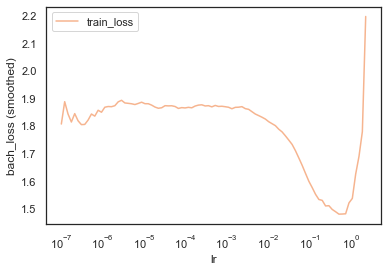

In [52]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=8)
_ = lr_finder.plot()

In [53]:
lr_finder.get_best_lr()

0.050941380148164093

In [54]:
model.optimizer.set_lr(lr_finder.get_best_lr())

In [55]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[1s / 1s],		train_loss: 0.4462,	val_loss: 2.3572
1:	[1s / 3s],		train_loss: 0.3779,	val_loss: 4.5159
2:	[1s / 5s],		train_loss: 0.3761,	val_loss: 0.4008
3:	[1s / 6s],		train_loss: 0.3730,	val_loss: 4.2772
4:	[1s / 8s],		train_loss: 0.3725,	val_loss: 2.2260
5:	[1s / 10s],		train_loss: 0.3704,	val_loss: 3.3952
6:	[2s / 12s],		train_loss: 0.3697,	val_loss: 1.5997
7:	[1s / 14s],		train_loss: 0.3723,	val_loss: 1.2817
8:	[2s / 16s],		train_loss: 0.3702,	val_loss: 7.6783
9:	[2s / 18s],		train_loss: 0.3710,	val_loss: 1.1551
10:	[3s / 22s],		train_loss: 0.3735,	val_loss: 8.1479
11:	[2s / 24s],		train_loss: 0.3709,	val_loss: 0.6147
12:	[1s / 26s],		train_loss: 0.3726,	val_loss: 2.0394


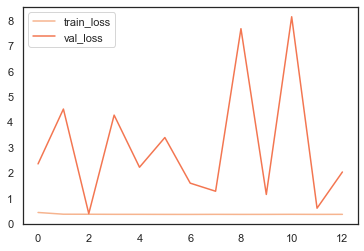

In [56]:
_ = log.plot()

In [57]:
surv = model.predict_surv_df(x_test)

In [58]:
model.sub = 10

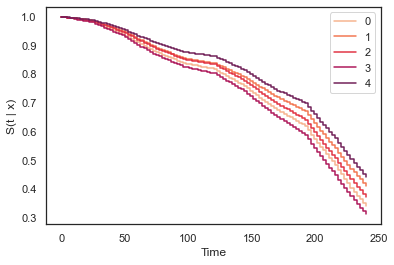

In [59]:
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [60]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [61]:
ev.concordance_td('antolini')

0.8300134157691937

In [62]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)

In [63]:
ev.integrated_brier_score(time_grid) 

0.1215123589276511

In [64]:
ev.integrated_nbll(time_grid) 

0.37802671214865163